In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

In [2]:
import sys
import os
sys.path.append("../../")

In [3]:
from axion_kSZ_source.auxiliary.helper_functions import is_array

In [4]:
r_vals = np.arange(20.0, 180.0, 2.0)
filter="sharpK"
diff = "5point"
m_a=1e-24

In [5]:
derivs = np.load(f"/scratch/r/rbond/gfarren/axion_kSZ/fisher_outputs/{filter}_filter_{diff}_rule/{filter}_{diff}_test_derivs_ma={m_a:.3E}.npy")

In [6]:
derivs.shape

(36, 10, 5, 80)

In [7]:
out_path="/scratch/r/rbond/gfarren/axion_kSZ/fisher_outputs/"
prefix="gaussian_5point"
f"{out_path}{prefix}_test_derivs_ma"

'/scratch/r/rbond/gfarren/axion_kSZ/fisher_outputs/gaussian_5point_test_derivs_ma'

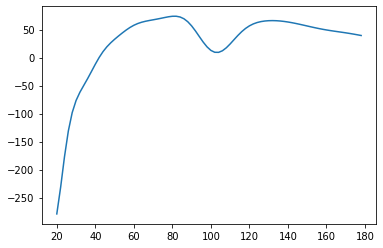

In [8]:
plt.plot(r_vals, derivs[0,0,0,:])

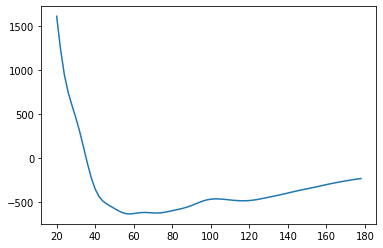

In [9]:
plt.plot(r_vals, derivs[0,1,0,:])

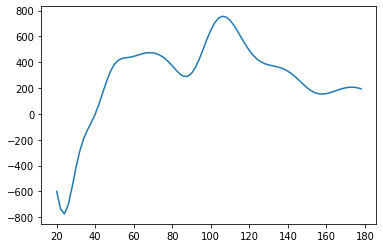

In [10]:
plt.plot(r_vals, derivs[0,2,0,:])

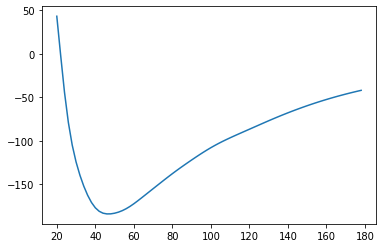

In [11]:
plt.plot(r_vals, derivs[0,3,0,:])

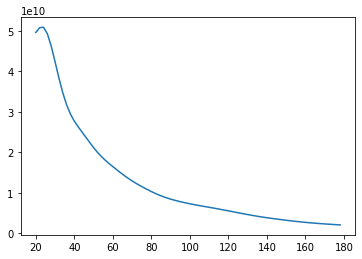

In [12]:
plt.plot(r_vals, derivs[0,4,0,:])

In [13]:
fisher = np.load(f"/scratch/r/rbond/gfarren/axion_kSZ/fisher_outputs/{filter}_filter_{diff}_rule/{filter}_{diff}_test_fisher_matrices_ma={m_a:.3E}.npy", allow_pickle=True)

In [14]:
axion_abundances = np.array([1.0e-04, 1.6e-04, 2.5e-04, 4.0e-04, 6.3e-04, 1.0e-03, 1.6e-03, 2.5e-03, 4.0e-03, 6.3e-03, 1.0e-02, 1.6e-02, 2.5e-02, 4.0e-02, 5.3e-02, 6.3e-02, 1.0e-01, 1.1e-01, 1.6e-01, 2.1e-01, 2.5e-01, 2.6e-01, 3.2e-01, 3.7e-01, 4.0e-01, 4.2e-01, 4.7e-01, 5.3e-01, 5.8e-01, 6.3e-01, 6.8e-01, 7.4e-01, 7.9e-01, 8.4e-01, 8.9e-01, 9.5e-01])
fractional_step_sizes = np.array([0.05, 0.1, 0.2, 0.4])

0 0.12748113694223995
1 0.3517606897900489
2 nan
3 nan


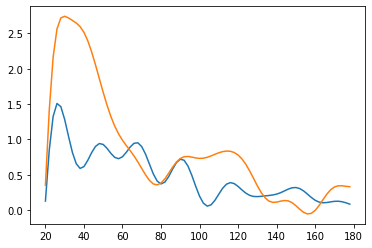

In [15]:
m_i=-5
z_i=4
for i in range(len(fractional_step_sizes)):
    print(i, derivs[m_i,5+i,z_i,0])
    plt.plot(r_vals, derivs[m_i,5+i,z_i,:])

In [16]:
axion_abundances[-24]

0.025

In [17]:
axion_constraints = np.full((len(axion_abundances), len(fractional_step_sizes)), np.nan)

In [18]:
for i,frac in enumerate(axion_abundances):
    for j in range(len(fractional_step_sizes)):
        axion_constraints[i,j] = np.sqrt(np.linalg.inv(fisher[len(fractional_step_sizes)*i+j]).diagonal()[5])

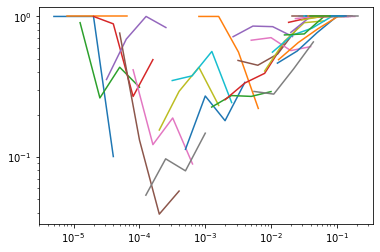

In [19]:
for i,frac in enumerate(axion_abundances):
    plt.plot(fractional_step_sizes*frac, np.clip(frac+2*axion_constraints[i], 0.0, 1.0))
plt.axhline(0.0)
plt.yscale('log')
plt.xscale('log')

<ipython-input-20-d0c3f3a56f02>:1: RuntimeWarning: All-NaN slice encountered
  plt.errorbar(axion_abundances, axion_abundances, yerr=2*np.nanmax(axion_constraints, axis=-1), fmt="x")


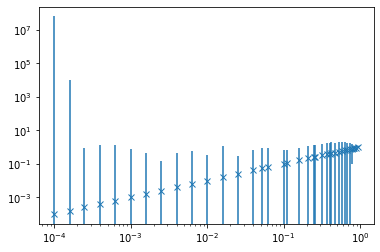

In [20]:
plt.errorbar(axion_abundances, axion_abundances, yerr=2*np.nanmax(axion_constraints, axis=-1), fmt="x")
plt.yscale('log')
plt.xscale('log')

<ipython-input-23-c51f1ad845e1>:2: RuntimeWarning: All-NaN slice encountered
  plt.plot((axion_constraints[i,:]-np.nanmax(axion_constraints[i,:]))/axion_abundances[i])


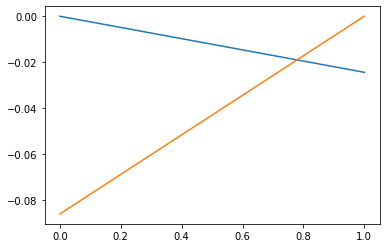

In [23]:
for i in range(-5, 0, 1):
    plt.plot((axion_constraints[i,:]-np.nanmax(axion_constraints[i,:]))/axion_abundances[i])

In [22]:
fisher.shape

(144,)